# Table of Contents
* [1. load](#1.-load)
* [2. simple words](#2.-simple-words)
* [3. analysis](#3.-analysis)
* [4. tag sentences](#4.-tag-sentences)
* [5. parse examples](#5.-parse-examples)
	* [5.1 token exp](#5.1-token-exp)
* [6. clean and spellcheck](#6.-clean-and-spellcheck)
	* [6.1 grammer experiment](#6.1-grammer-experiment)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

from copy import deepcopy
import pickle
import os
import json
from tqdm import tqdm
from tqdm import tqdm_notebook

from IPython.display import Image
import PIL.Image as pil
import random
import cv2
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

from nltk.parse.stanford import StanfordParser
from nltk.tree import ParentedTree
from nltk.parse.corenlp import CoreNLPServer
from nltk.parse.corenlp import CoreNLPParser

from word_mod import zipf_frequency

import nltk
import spacy
import string
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer

from word_mod import zipf_frequency


from anigen_tools.parsing import sanitize_text
from anigen_tools.parsing import sentence_splitter

from nltk.corpus import stopwords

In [ ]:
cached_sw = stopwords.words("english") + list(string.punctuation)

In [ ]:
nlp = spacy.load('en')

core_nlp_base = '/Users/schwenk/wrk/animation_gan/phrase_cues/deps/stanford_core_nlp/stanford-corenlp-full-2017-06-09/'
core_parser = CoreNLPParser(url='http://localhost:9000')    

punct_set = set(string.punctuation)
punct_set.remove('.')

# 1. load

In [2]:
out_data_dir = '/Users/schwenk/wrk/pictionary/phrase_gen/sandbox-anikem/out/'

In [3]:
verb_df = pd.read_csv(out_data_dir + 'verbs.txt', header=None, names=['verb'])
situations_df = pd.read_csv(out_data_dir + 'full_situations.txt', header=None, names=['situation'])

In [4]:
situations_df.head()

,situation
0,the person loads a cartridge holder
1,the man tastes the food
2,the person slices the apple
3,the woman emerges from cave
4,the case displays the gem


In [5]:
verb_df[verb_df['verb'].str.contains('teach')]

,verb
445,teaching


In [6]:
verb_df.shape

(504, 1)

In [7]:
verb_df['len'] = verb_df['verb'].apply(lambda x: len(x))

In [8]:
# verb_df.sort_values('len')

In [66]:
# situations_df[situations_df['situation'] == 'the male child']

In [10]:
# ing_verbs = verb_df[verb_df['verb'].str.contains('ing')]

not abstract, easy

# 2. simple words

In [11]:
with open('basic_words.csv') as f:
    read_article = f.read()

In [12]:
word_data_dir = '/Users/schwenk/wrk/pictionary/BasicEnglishTranslator/data/'

In [13]:
os.listdir(word_data_dir)

['articles.pickle',
 'basic_english.pickle',
 'sentences.pickle',
 'basic_english_words.csv',
 'basic_english_wordlist.csv',
 'basictemp_paths.pickle',
 'basic_english_book_words.pickle',
 'basic_english - Copy.pickle',
 'contractions.csv',
 'wikipedia.pickle',
 'sentences - Copy.pickle']

In [14]:
with open(word_data_dir + 'basic_english.pickle', 'rb') as f:
    all_words = pickle.load(f) 

In [15]:
simple_words = pd.read_csv(word_data_dir + 'basic_english_words.csv')

In [63]:
# _ = simple_words['WORD'].apply(lambda x: len(x)).hist(bins=14)

In [64]:
simple_words.head()

,WORD
0,a
1,able
2,about
3,account
4,acid


# 3. filtering sample

In [20]:
description_corpus = ' '.join(situations_df['situation'])

In [21]:
description_corpus[:100]

'the person loads a cartridge holder the man tastes the food the person slices the apple the woman em'

In [22]:
tokenized_corpus = word_tokenize(description_corpus)

normalized_tokens = []
for toke in tokenized_corpus:
    clean_toke = toke.strip().lower()
    if clean_toke not in cached_sw and clean_toke:
        normalized_tokens.append(clean_toke)

In [23]:
word_counts = Counter(normalized_tokens)
most_common = word_counts.most_common(200)

In [24]:
filtered_words = [w for w, count in word_counts.items() if count == 1]

In [25]:
sentences = situations_df['situation'].tolist()

In [26]:
len(sentences)

62160

In [25]:
len(set(sentences))

61622

In [30]:
import language_check

gram_checker = language_check.LanguageTool('en-US')
gram_checker.disabled = set(['UPPERCASE_SENTENCE_START'])
# gram_checker.disable_spellchecking()

def grammar_check_phrases(dataset):
    corrected = {}
    passed = []
    for sentence in dataset:
        corrections = gram_checker.check(sentence)
        if corrections:
            corrected[sentence] = corrections
        else:
            passed.append(sentence)
    return corrected, passed

In [31]:
test_sent = sentences[1]

In [33]:
# sent_gram_errors, passed_sents = grammar_check_phrases(tqdm(sentences))

In [165]:
len(passed_sents) / len(sentences)

0.9645086556406461

In [164]:
len(passed_sents)

59950

# 4. tag sentences

In [43]:
def get_pos_tags(sentence):
    constituent_parse  = [list(i)[0] for i in core_parser.raw_parse_sents([sentence])][0]
    pos_tags = constituent_parse.pos()
    return pos_tags

def filter_pos_tags(tagged_sent):
    include_as_article = []
    for word, tag in tagged_sent:
        if tag == 'DT':
            include_as_article.append('True')
        else:
            include_as_article.append('False')
    return include_as_article

def least_common_word(sent):
    wlfs = [zipf_frequency(w, 'en') for w in sent.split()]
    lowest_freq = min(wlfs)
    return lowest_freq > 4.7

def form_strings(tagged_sentence):
    words = [w[0] for w in tagged_sentence]
    include_word = filter_pos_tags(tagged_sentence)
    return f"{' '.join(words)} # {' '.join(include_word)}"

def form_strings_w_pos(tagged_sentence):
    words = [w[0] for w in tagged_sentence]
    include_word = [w[1] for w in tagged_sentence]
    return f"{' '.join(words)} # {' '.join(include_word)}"

In [44]:
with open('unique_parsed_sents.pkl', 'rb') as f:
    unique_parsed_sents = pickle.load(f)

In [45]:
simple_sentences = [sent for sent in unique_parsed_sents if least_common_word(sent)]

In [46]:
# with open('unique_parsed_sents.pkl', 'wb') as f:
#     pickle.dump(unique_parsed_sents, f)

In [47]:
some_sents = unique_parsed_sents[3]

In [49]:
tagged_sentences = [get_pos_tags(s) for s in simple_sentences]

In [50]:
vocab_complete = list(set(normalized_tokens))

In [51]:
vocab = list(set([w[0].lower() for s in tagged_sentences for w in s if w[1] in ['NN', 'NNS', 'NNP', 'NNPS']]))

In [52]:
voc_ser = pd.Series(vocab)

In [53]:
voc_ser.to_csv('cleaned_sentences_nouns.txt', index=False, header=None)

In [54]:
voc_ser.shape

(269,)

In [31]:
vw = vocab_complete[0]
zipf_frequency(vw, 'en')

3.22

In [40]:
unique_parsed_sents[0]

'bald eagle is swooping in blue sky'

In [39]:
len(simple_sentences)

1405

In [55]:
build_output = pd.Series([form_strings_w_pos(s) for s in tagged_sentences])

In [56]:
build_output.to_csv('cleaned_sentences_simple_pos_tags.txt', index=False, header=None)

In [ ]:
# def custom_filter_sentences(sentences):
#     required = ['a ', 'the ']
#     filtered = []
#     for sent in sentences:

# 5. parse examples

In [17]:
test_vid = random.choice(complete_ds.data)
test_vid = complete_ds.data[300]
test_vid = [v for v in complete_ds.data  if v.gid() == 's_01_e_08_shot_003729_003803'][0]
print(test_vid.gid())

s_01_e_08_shot_003729_003803


In [20]:
vid_text = test_vid.description()
vid_text = sanitize_text(vid_text)
raw_sentences = sentence_splitter.tokenize(vid_text)
sentences = [' '.join([w for w in wordpunct_tokenize(s) if set(w) - punct_set]).replace(' .',  '.') for s in raw_sentences]
constituent_parse = [list(i)[0] for i in core_parser.raw_parse_sents(sentences)]

print(vid_text)
s1 = constituent_parse[0]

Fred is in the playroom playing pool. The middle aged man in red suit walks up to him with the chalk and starts a conversation.


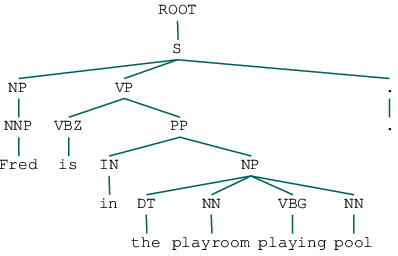

In [21]:
s1

In [22]:
from nltk.draw.tree import TreeView

In [24]:
s1 = constituent_parse[1]
TreeView(s1)._cframe.print_to_file('s2.ps')

In [8]:
from anigen_tools.parsing import parse_description

In [9]:
from fuzzywuzzy import fuzz

In [2231]:
grammar = r"""
  NP: {<DT|PP\$>?<JJ>*<NN>}   # chunk determiner/possessive, adjectives and noun
  {<NNP>+}                # chunk sequences of proper nouns
  {<NN>+}                 # chunk consecutive nouns
  """




cp = nltk.RegexpParser(grammar)
parsed_sent = cp.parse(sent_parses[0])
for npstr in extract_np(parsed_sent):
    print (npstr)

The red-haired businessman
accountant
the phone
his office


In [2445]:
# def compute_word_spans(doc, parsed_sent, ):
#     words = [word for sent.flatten().leaves() in parsed_sent for word in sent]
#     word_spans = []
#     for idx, word in enumerate(words):
#         if word_spans:
#             last_idx = word_spans[-1][1]
#             word_spans.append((last_idx, last_idx + 1 + len(word)))
#         else:
#             word_spans.append((0, len(word)))
#     return word_spans

In [2466]:
def extract_np(psent):
    for subtree in psent.subtrees():
        if subtree.label() == 'NP':
            subprod = subtree.productions()[0].unicode_repr()
            if 'NN' in subprod or 'NNP' in subprod:
                yield ' '.join(word for word in subtree.leaves())

                
# def extract_np_spans(doc, noun_chunks):
#     chunk_spans = []
#     for np in noun_chunks:
#         np_span= [(m.start(), m.end()) for m in re.finditer(np, doc)]
#         chunk_spans.append(np_span)
#     return chunk_spans


def compute_token_spans(const_parse_sent, txt):
    tokens = const_parse_sent.leaves()
    offset = 0
    for token in tokens:
        offset = txt.find(token, offset)
        yield token, offset, offset+len(token)
        offset += len(token)

        
def assign_word_spans(noun_phrases_w_spans, doc, token_spans):
    chunk_spans = []
    for np in noun_phrases_w_spans:
        char_span = [(m.start(), m.end()) for m in re.finditer(np, doc)][0]
        start, end = char_span
        start_w, end_w = None, None
        for w_idx, token_span in enumerate(token_spans):
            token, ts, te = token_span
            if ts == start:
                start_w = w_idx
            if te == end:
                end_w = w_idx + 1
        if type(start_w) == int and type(end_w) == int:
            chunk_spans.append([start_w, end_w])
        else:
            print('failed')
    return chunk_spans


def np_chunker(doc, parsed_sents):
    noun_phrases = [list(extract_np(sent)) for sent in parsed_sents]
#     noun_phrase_spans = [list(extract_np_spans(doc, sent)) for sent in noun_phrases]
    token_spans = [list(compute_token_spans(sent, doc)) for sent in parsed_sents]
    noun_phrase_spans = [assign_word_spans(noun_phrases[n], doc, token_spans[n]) for n in range(len(parsed_sents))]
    return {'chunks': noun_phrase_spans, 'named_chunks': noun_phrases}

# 6. clean and spellcheck

In [15]:
import enchant
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize

from fuzzywuzzy import fuzz
# import difflib
# import diff_match_patch

# dmp = diff_match_patch.diff_match_patch()

edict = enchant.Dict("en_US")
anglo_edict = enchant.Dict("en_UK")
cached_sw = stopwords.words("english") + list(string.punctuation)

main_characters = {
}

other_chars_names = []

other_words = []

words_to_remove = []

_ = [edict.remove_from_session(word) for word in words_to_remove]
_ = [[edict.add(char_word.lower()) for char_word in char.split()] for char in list(main_characters) + other_chars_names + other_words]

_ = [anglo_edict.remove_from_session(word) for word in words_to_remove]

manual_corrections = {
                     }

def check_mispelled(word):
    return word and word.isalpha() and not (edict.check(word))

def check_word_rules(word):
    split_len = 2 < min([len(w) for w in word.split()])
    not_proper = word[0].islower()
    return not_proper and split_len

def correct_spelling_error(misspelled_word):
    if misspelled_word in manual_corrections:
        return manual_corrections[misspelled_word]
    suggested_spellings = edict.suggest(misspelled_word)
    match_ratios = [fuzz.token_sort_ratio(misspelled_word, word) for word in suggested_spellings]
    words_sorted_by_ratio = sorted(zip(suggested_spellings, match_ratios), key=lambda x: x[1], reverse=True)
    words_sorted_by_ratio = [wordscore for wordscore in words_sorted_by_ratio if check_word_rules(wordscore[0])]
    check_compounds = [word[0] for word in words_sorted_by_ratio if word[0].replace(' ', '') == misspelled_word]
    if check_compounds:
        return check_compounds[0]
    if words_sorted_by_ratio[0][1] > 80:
        return words_sorted_by_ratio[0][0]

    for word, score in words_sorted_by_ratio:
        if score >= 75 and word[0] == misspelled_word[0]:
            return word
        elif score >= 75:                    
            return word
    return None

def apply_spelling_fix(orig_text):
    orig_text_tokens = wordpunct_tokenize(orig_text)
    processed_tokens = []
    for token in orig_text_tokens:
        norm_token = token.lower()
        if len(norm_token) < 4:
            processed_tokens.append(token)
            continue
        if check_mispelled(norm_token):
            suggested_replacements = edict.suggest(token)
            replacement_text = correct_spelling_error(norm_token, suggested_replacements)
            if replacement_text:
                if norm_token[0].isupper():
                    replacement_text = upper(replacement_text[0]) + replaced_text[1:]
                processed_tokens.append(replacement_text)
            else:
                processed_tokens.append(token)
        else:
            processed_tokens.append(token)
    return ' '.join(processed_tokens)

def diff_corrected_text(orig_text, corrected_text):
    diff = dmp.diff_main(orig_text, corrected_text)
    return HTML(dmp.diff_prettyHtml(diff))

def specify_lesson_q_path(lesson):
    pass

def apply_spelling_and_grammar_to_ds(ck12_ds):
    return

def spellcheck_entry(entry_words):
    misspellings = [check_mispelled(word) for word in entry_words]
    if sum(misspellings):
        for idx, is_mispelled in enumerate(misspellings):
            if is_mispelled:
                suggested_replacement = correct_spelling_error(entry_words[idx])
                if suggested_replacement:
#                     words_changed.append([char_name_words[idx], suggested_replacement])
                    entry_words[idx] = suggested_replacement
        return entry_words
    else:
        return None

def spellcheck_video(video):
    corrected_words = []
    for entity in video._data['characters'] + video._data['objects']:
        if 'entityLabel' not in entity.data().keys():
            pass
        entry_words = wordpunct_tokenize(entity.data()['entityLabel'])
#         print(entry_words)
        new_corrected_words = spellcheck_entry(entry_words)
        if new_corrected_words:
            entity._data['originalSpelling'] = entity._data['entityLabel']
            entity._data['entityLabel'] = ' '.join(new_corrected_words).replace(' , ', ', ').replace(' . ', '.')
            corrected_words.append(new_corrected_words)
    description_words = wordpunct_tokenize(video.description())
    new_corrected_words = spellcheck_entry(description_words)
    if new_corrected_words:
        video._data['originalDescription'] = video._data['description']
        video._data['description'] = ' '.join(new_corrected_words).replace(' , ', ', ').replace(' . ', '.')
        corrected_words.append(new_corrected_words)
    return corrected_words

def spellcheck_dataset(dataset):
    corrected = {}
    for vid in dataset:
        try:
            corrections = spellcheck_video(vid)
            if corrections:
                corrected[vid.gid()] = corrections
        except:
            pass
#             print(vid.gid())
    return corrected

def grammar_check_video(video):
    all_errors = []
    for entity in video._data['characters']:
        errors = gram_checker.check(entity.data()['entityLabel'])
        if errors:
            all_errors.append(errors)
    return all_errors

def grammar_check_dataset(dataset):
    corrected = {}
    for vid in dataset:
        corrections = grammar_check_video(vid)
        if corrections:
            corrected[vid.gid()] = corrections
    return corrected

## 6.1 grammer experiment

In [12]:
import language_check

gram_checker = language_check.LanguageTool('en-US')
gram_checker.disabled = set(['UPPERCASE_SENTENCE_START'])
gram_checker.disable_spellchecking()

In [16]:
desc_with_errors = {}
corrected_desc = {}
for diag, desc_text in diagram_desc_dict.items():
    errors = gram_checker.check(desc_text)
    if errors:
        desc_with_errors[diag] = errors
        corrected_desc[diag] = gram_checker.correct(desc_text)

In [ ]:
# corrected_words = spellcheck_entry(test_ent)
# if corrected_words:
#     t = ' '.join(corrected_words).replace(' , ', ', ').replace(' . ', '.')

In [ ]:
# ' '.join(char_name_words).replace(' , ', ', ').replace(' . ', '.')

In [57]:
# spelling_and_grammar_issue_vids = set(gram_errs.keys()).union(set(corrected_words.keys()))

In [58]:
import viterbi_tagger, perceptron_tagger, cfg

# test values for developers
test_sentence = ["I", "saw", "the", "duck"]
cfg_test = ["NNP","VBD","NNP"]
from nltk.corpus import conll2000, brown

In [ ]:
# Build HMM
print("Generating Hidden Markov Model...")
viterbi_tagger = viterbi_tagger.PartOfSpeechTagger()
# Build probability distributions for each of the corpora we want to use
print("Building POS tag probability distributions based on...")
print("Corpora 1: Conll2000,")
viterbi_tagger.buildProbDist(conll2000)
print("Corpora 2: Brown.")
viterbi_tagger.buildProbDist(brown)

In [ ]:
#Train the AP Tagger weights
print("Prepare Averaged Perceptron tagger based on tagged corpora")
# taggerAP = perceptron_tagger.AP_Tagger(False)
#
# Build CFG rule set based on treebank
print("Generating Context Free Grammar based on Treebank...")
cfg_checker = cfg.Grammar()
tbank_grammar = cfg_checker.buildFromTreebank()
#
# Loop input to get and check sentences
print("If an input word is not in the corpora, the averaged perceptron \
tagger will be used instead of the Viterbi tagger.\n")

In [ ]:
# while True:
#     tag_sequence = viterbi_tagger.inputToPOS()
#     print("TAG SEQUENCE:", tag_sequence)
#     cfg_checker.verify(tbank_grammar, tag_sequence)